# JetBrains IDE Tool Window Usage Analysis

In this notebook, we analyze usage data for a JetBrains IDE tool window. The dataset records events when the tool window was **opened** or **closed**. 

Our main goal is to investigate whether the **duration** of a tool window being open differs depending on whether it was triggered **manually** by the user or **automatically** by the IDE.

### Analysis Steps
We will follow these steps:

1. Load and explore the dataset  
2. Clean and prepare the data  
3. Reconstruct open/close sessions  
4. Filter outliers
5. Compare manual vs automatic patterns  
6. Visualize results and summarize findings


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

df = pd.read_csv('toolwindow_data.csv')

df.head()

,timestamp,event,open_type,user_id
0,1752250204033,opened,manual,1
1,1751836141616,closed,NaN,2
2,1752304475081,closed,NaN,3
3,1752498934494,opened,auto,4
4,1752141991110,closed,NaN,5


## Dataset Overview

The dataset contains logs of tool window usage events, with the following columns:

1. **timestamp**: when the event occurred (in epoch milliseconds)  
2. **event**: type of event (`open` or `close`)  
3. **open_type**: method of opening (`manual` or `auto` for `open` events; `NaN` for `close` events)  
4. **user_id**: anonymized user identifier  

We will start by inspecting the dataset to understand its **structure**, **time range**, and **distribution of events and open types**.


In [2]:
df.info()

df["datetime"] = pd.to_datetime(df["timestamp"], unit="ms")


print("Date range in dataset:", df["datetime"].min().strftime("%Y-%m-%d %H:%M:%S.%f")[:-3], "to", df["datetime"].max().strftime("%Y-%m-%d %H:%M:%S.%f")[:-3])
print("\nNumber of unique users:", df["user_id"].nunique())
print("\nEvent counts:")
print(df["event"].value_counts())
print("\nOpen type counts:")
print(df["open_type"].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3503 entries, 0 to 3502
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  3503 non-null   int64 
 1   event      3503 non-null   object
 2   open_type  1865 non-null   object
 3   user_id    3503 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 109.6+ KB
Date range in dataset: 2025-07-03 21:54:15.846 to 2025-07-23 23:01:03.785

Number of unique users: 205

Event counts:
event
opened    1865
closed    1638
Name: count, dtype: int64

Open type counts:
open_type
auto      1204
manual     661
Name: count, dtype: int64


## Data Quality Check

Before reconstructing tool window sessions, we first examine the **quality and consistency** of the dataset. This step ensures that subsequent analyses are based on reliable data.

Specifically, we check:

1. **Duplicate rows** – Identify any completely identical rows that might distort counts or durations.  
2. **Missing `open_type` in opened events** – Verify that every `open` event has a valid `open_type` (`manual` or `auto`).  
3. **Unexpected `open_type` in closed events** – Ensure that `close` events do not have an `open_type`.  
4. **User activity patterns** – Inspect the number of events per user and the time span of their activity to understand dataset coverage and detect anomalies.


In [3]:
df = df.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

opened_events = df[df['event'] == 'opened']
missing_open_type = opened_events['open_type'].isna().sum()
print(f"Opened events missing open_type: {missing_open_type}")

closed_events = df[df['event'] == 'closed']
closed_with_type = closed_events['open_type'].notna().sum()
print(f"Closed events with open_type: {closed_with_type}")

user_event_counts = df.groupby('user_id').agg({
    'event': 'count',
    'timestamp': lambda x: (x.max() - x.min()) / 1000 / 60 / 60  # hours
}).rename(columns={'event': 'total_events', 'timestamp': 'time_span_hours'})

print(f"\nAverage events per user: {user_event_counts['total_events'].mean():.1f}")
print(f"Average time span per user: {user_event_counts['time_span_hours'].mean():.1f} hours")


Number of duplicate rows: 0
Opened events missing open_type: 0
Closed events with open_type: 0

Average events per user: 17.1
Average time span per user: 111.0 hours


### Checking for Messy Situations

Real-world event logs often contain inconsistencies that need to be identified before reconstructing sessions. Common issues include:

- **Close events without a prior open** – indicates unmatched `close` events.  
- **Multiple open events in a row** – suggests overlapping sessions or missing `close` events.  
- **Open events without a matching close at the end of the dataset** – sessions that never closed.  

We will count the occurrences of each of these situations to assess the extent of anomalies in the dataset. This helps us handle edge cases properly when reconstructing tool window sessions.


In [4]:
orphan_closes = 0
multiple_opens = 0
opens_without_close = 0

for user, group in df.groupby("user_id"):
    open_count = 0
    for idx, row in group.iterrows():
        if row["event"] == "opened":
            if open_count > 0:
                multiple_opens += 1
            open_count += 1
        elif row["event"] == "closed":
            if open_count == 0:
                orphan_closes += 1
            else:
                open_count -= 1
                
    if open_count > 0:
        opens_without_close += open_count

print("Messy situations detected:")
print("1. Close events without prior open:", orphan_closes)
print("2. Multiple opens in a row:", multiple_opens)
print("3. Opens without a matching close at end:", opens_without_close)


Messy situations detected:
1. Close events without prior open: 8
2. Multiple opens in a row: 645
3. Opens without a matching close at end: 235


## Reconstruct Open/Close Sessions

Next, we reconstruct **tool window sessions** by pairing each `opened` event with its corresponding `closed` event.

### Strategy

- Iterate through events **chronologically** for each user.  
- Pair each `opened` event with the next `closed` event.  
- Handle edge cases:
  - **Multiple opens without close**: ignore all but the last open before a close.  
  - **Close without open**: ignore these orphan closes.  
  - **Open without close**: ignore forgotten sessions.  

This approach ensures that session durations are **realistic** and **comparable**, allowing us to directly analyze differences between manually and automatically opened sessions.


In [5]:
def reconstruct_sessions(user_df):
    sessions = []
    current_open = None
    
    for idx, row in user_df.iterrows():
        if row['event'] == 'opened':
            if current_open is None:
                current_open = {
                    'user_id': row['user_id'],
                    'open_timestamp': row['timestamp'],
                    'open_type': row['open_type'],
                    'open_datetime': row['datetime']
                }
            
        elif row['event'] == 'closed':
            if current_open is not None:
                # Complete the session
                duration_ms = row['timestamp'] - current_open['open_timestamp']
                duration_seconds = duration_ms / 1000
                
                sessions.append({
                    'user_id': current_open['user_id'],
                    'open_type': current_open['open_type'],
                    'open_timestamp': current_open['open_timestamp'],
                    'close_timestamp': row['timestamp'],
                    'duration_seconds': duration_seconds,
                    'open_datetime': current_open['open_datetime'],
                    'close_datetime': row['datetime']
                })
                current_open = None
    
    return sessions

all_sessions = []
for user_id, user_df in df.groupby('user_id'):
    user_sessions = reconstruct_sessions(user_df)
    all_sessions.extend(user_sessions)

sessions_df = pd.DataFrame(all_sessions)

print(f"Total reconstructed sessions: {len(sessions_df)}")
print(f"Sessions by open type:")
print(sessions_df['open_type'].value_counts())




Total reconstructed sessions: 1622
Sessions by open type:
open_type
auto      988
manual    634
Name: count, dtype: int64


## Detecting and Removing Outliers

Real-world session data can contain **extreme durations** that do not represent typical user behavior:

- **Long sessions**: Sessions lasting more than **8 hours** (e.g., IDE left open) are likely anomalies.  
- **Very short sessions**: Sessions shorter than **1 second** may result from accidental clicks or mis-logged events.  

To ensure our analysis is robust and reliable, we will **remove both types of outliers** before performing visualizations and statistical comparisons.


In [6]:
sessions_df['duration_days'] = sessions_df['duration_seconds'] / (60*60*24)

long_sessions = sessions_df[sessions_df['duration_seconds'] > 8*60*60]
print(f"Number of sessions longer than 8 hours: {len(long_sessions)}")

very_short = sessions_df[sessions_df['duration_seconds'] < 1]
print(f"Sessions shorter than 1 second: {len(very_short)}")


Number of sessions longer than 8 hours: 107
Sessions shorter than 1 second: 71


In [7]:
filtered_sessions = sessions_df[
    (sessions_df['duration_seconds'] <= 8*60*60) &
    (sessions_df['duration_seconds'] >= 1)
].copy()

print(f"Remaining sessions: {len(filtered_sessions)}")


Remaining sessions: 1444


## Session Duration Distribution

To understand the characteristics of tool window sessions, we explore their **durations** using both descriptive statistics and visualizations:

- **Summary statistics**: Key metrics such as mean, median, standard deviation, and quartiles.  
- **Histogram (log scale)**: Displays the distribution of session durations. Since most sessions are short but a few are extremely long, the y-axis is logarithmic to reveal patterns more clearly.  
- **Box plot by open type**: Compares session durations between **manual** and **auto** sessions. The log scale on the y-axis reduces the influence of extreme values and highlights differences between groups.

### Why Log Transformation?

In our dataset, session durations vary from a few seconds to several hours, resulting in a **highly right-skewed distribution**.  
Most sessions are very short, while a small number last unusually long — which can distort averages and visualizations.  

Applying a **logarithmic transformation (`log(Duration + 1)` add 1 to avoid log(0))** compresses extreme values and makes the distribution more balanced.  
This allows for clearer visualizations, more robust statistical testing, and a fairer comparison between **manual** and **automatic** tool window sessions.

Log-Transformed Duration Statistics:
count    1444.000000
mean        4.598283
std         2.336483
min         0.699626
25%         2.634081
50%         4.572599
75%         6.341975
max        10.257013
Name: log_duration, dtype: float64


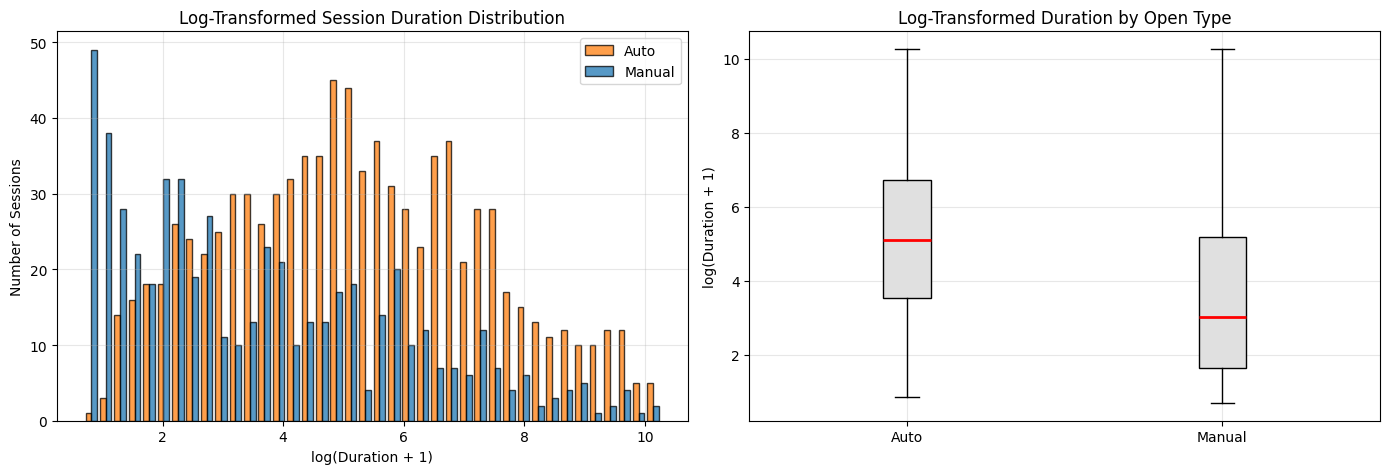

In [8]:
filtered_sessions['log_duration'] = np.log1p(filtered_sessions['duration_seconds'])

print("Log-Transformed Duration Statistics:")
print(filtered_sessions['log_duration'].describe())

manual_sessions = filtered_sessions[filtered_sessions['open_type'] == 'manual']
auto_sessions = filtered_sessions[filtered_sessions['open_type'] == 'auto']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Histogram ---
axes[0].hist(
    [auto_sessions['log_duration'], manual_sessions['log_duration']],
    bins=40,
    color=['#ff7f0e', '#1f77b4'],
    label=['Auto', 'Manual'],
    edgecolor='black',
    alpha=0.75
)
axes[0].set_xlabel('log(Duration + 1)')
axes[0].set_ylabel('Number of Sessions')
axes[0].set_title('Log-Transformed Session Duration Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# --- Boxplot ---
axes[1].boxplot(
    [auto_sessions['log_duration'], manual_sessions['log_duration']],
    tick_labels=['Auto', 'Manual'],
    patch_artist=True,
    boxprops=dict(facecolor='#e0e0e0', color='black'),
    medianprops=dict(color='red', linewidth=2)
)
axes[1].set_ylabel('log(Duration + 1)')
axes[1].set_title('Log-Transformed Duration by Open Type')
axes[1].grid(alpha=0.3)

plt.suptitle('')
plt.tight_layout()
plt.show()


## Compare Manual vs Auto Opens

In this step, we compare the **session durations** between manual and automatic opens. The objectives are:

- Compute **summary statistics** (mean, median, standard deviation, quartiles) for both groups.  
- Calculate the **differences** in duration between manual and automatic opens.  
- Assess statistical significance using:
  - **Mann-Whitney U test** (non-parametric) - to determine whether the two distributions differ significantly
  - **Hodges-Lehmann estimator** (non-parametric) - to compute a confidence interval for the median difference between manual and auto sessions
  - **Welch's t-test** - applied to log-transformed durations to validate findings under approximate normality
- Determine **effect size** (rank-biserial correlation) to evaluate practical significance.  

This analysis helps identify whether the **method of opening a session** impacts how long it remains open.

We will first look at basic descriptive statistics and differences, and then perform **statistical tests** to evaluate significance and effect size.


In [9]:

manual_durations = filtered_sessions[filtered_sessions['open_type'] == 'manual']['duration_seconds']
auto_durations = filtered_sessions[filtered_sessions['open_type'] == 'auto']['duration_seconds']


print(f"\nManual Opens (n={len(manual_durations)}):")
print(f"  Mean: {manual_durations.mean():.2f} seconds")
print(f"  Median: {manual_durations.median():.2f} seconds")
print(f"  Std Dev: {manual_durations.std():.2f} seconds")
print(f"  25th percentile: {manual_durations.quantile(0.25):.2f} seconds")
print(f"  75th percentile: {manual_durations.quantile(0.75):.2f} seconds")

print(f"\nAuto Opens (n={len(auto_durations)}):")
print(f"  Mean: {auto_durations.mean():.2f} seconds")
print(f"  Median: {auto_durations.median():.2f} seconds")
print(f"  Std Dev: {auto_durations.std():.2f} seconds")
print(f"  25th percentile: {auto_durations.quantile(0.25):.2f} seconds")
print(f"  75th percentile: {auto_durations.quantile(0.75):.2f} seconds")

print(f"\nDifference:")
print(f"  Mean difference: {manual_durations.mean() - auto_durations.mean():.2f} seconds")
print(f"  Median difference: {manual_durations.median() - auto_durations.median():.2f} seconds")



Manual Opens (n=547):
  Mean: 660.27 seconds
  Median: 19.72 seconds
  Std Dev: 2586.53 seconds
  25th percentile: 4.21 seconds
  75th percentile: 179.26 seconds

Auto Opens (n=897):
  Mean: 1391.14 seconds
  Median: 162.69 seconds
  Std Dev: 3584.63 seconds
  25th percentile: 33.30 seconds
  75th percentile: 830.41 seconds

Difference:
  Mean difference: -730.87 seconds
  Median difference: -142.96 seconds


In [10]:
#Hodges–Lehmann CI
def hodges_lehmann_ci(x, y, n_bootstrap=5000, ci=95, seed=42):
    rng = np.random.default_rng(seed)
    diffs = np.subtract.outer(x, y).ravel()
    hl_est = np.median(diffs)
    hl_boot = []
    for _ in range(n_bootstrap):
        bx = rng.choice(x, len(x), replace=True)
        by = rng.choice(y, len(y), replace=True)
        hl_boot.append(np.median(np.subtract.outer(bx, by).ravel()))
    lower = np.percentile(hl_boot, (100 - ci) / 2)
    upper = np.percentile(hl_boot, 100 - (100 - ci) / 2)
    return hl_est, (lower, upper)

hl, hl_ci = hodges_lehmann_ci(manual_durations.to_numpy(), auto_durations.to_numpy())
print(f"Hodges–Lehmann typical shift: {hl:.2f} s")
print(f"95% CI (bootstrap): [{hl_ci[0]:.2f}, {hl_ci[1]:.2f}] s")


# Mann-Whitney
statistic, p_value = stats.mannwhitneyu(manual_durations, auto_durations, alternative='two-sided')
print(f"\nMann-Whitney U Test:")
print(f"  U-statistic: {statistic:.2f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")

n1, n2 = len(manual_durations), len(auto_durations)
rank_biserial = 1 - (2*statistic) / (n1 * n2)
print(f"  Effect size (rank-biserial): {rank_biserial:.3f}")

manual_durations = filtered_sessions[filtered_sessions['open_type'] == 'manual']['log_duration']
auto_durations = filtered_sessions[filtered_sessions['open_type'] == 'auto']['log_duration']

# Welch's t-test
t_stat, t_p_value = stats.ttest_ind(manual_durations, auto_durations, equal_var=False)
print(f"\nWelch's t-test (for reference):")
print(f"  t-statistic: {t_stat:.2f}")
print(f"  p-value: {t_p_value:.4f}")

Hodges–Lehmann typical shift: -79.27 s
95% CI (bootstrap): [-105.38, -57.59] s

Mann-Whitney U Test:
  U-statistic: 146622.50
  p-value: 0.0000
  Significant at α=0.05: Yes
  Effect size (rank-biserial): 0.402

Welch's t-test (for reference):
  t-statistic: -12.98
  p-value: 0.0000


## Session Duration Visualizations

To further explore differences between **manual** and **automatic** sessions, we will use two complementary visualizations:

1. **Violin Plot**  
   - Shows the full distribution of session durations for each group.  
   - Includes mean and median values to highlight central tendencies.  
   - Useful for visualizing the shape, spread, and potential multimodality in the data.

2. **Cumulative Distribution Function (CDF)**  
   - Plots the cumulative probability of session durations.  
   - Allows us to compare the proportion of sessions below any given duration between manual and automatic opens.  
   - Provides an intuitive view of distribution differences beyond summary statistics.

These visualizations help us understand both the **overall distribution** and the **relative behavior** of manual vs automatic sessions.


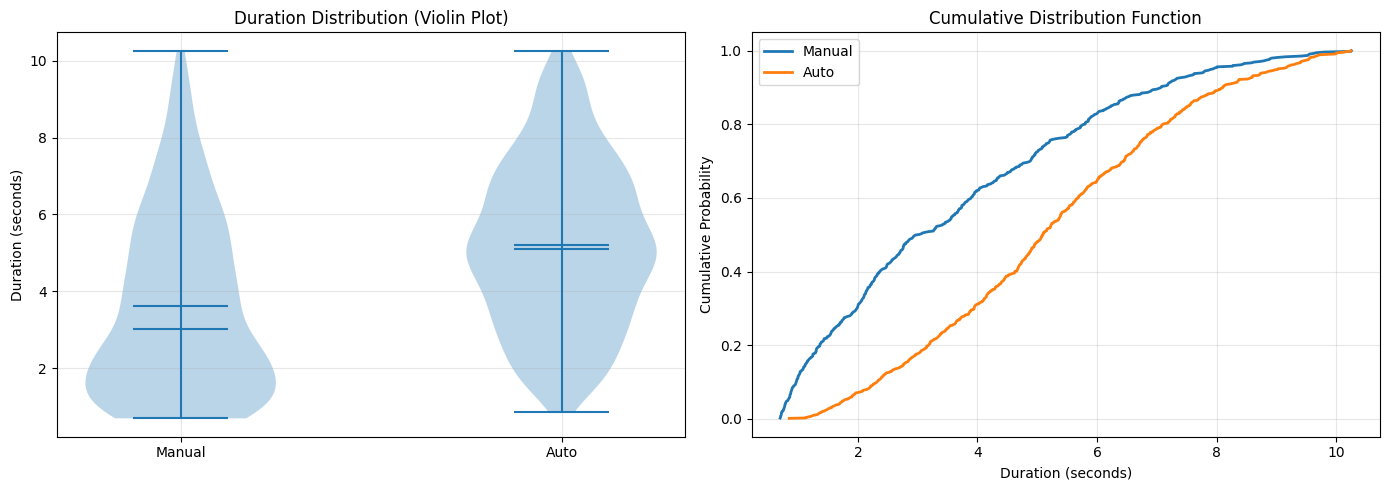

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

parts = axes[0].violinplot([manual_durations, auto_durations], 
                           positions=[1, 2], 
                           showmeans=True, 
                           showmedians=True)
axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(['Manual', 'Auto'])
axes[0].set_ylabel('Duration (seconds)')
axes[0].set_title('Duration Distribution (Violin Plot)')
axes[0].grid(alpha=0.3)


manual_sorted = np.sort(manual_durations)
auto_sorted = np.sort(auto_durations)
manual_cdf = np.arange(1, len(manual_sorted) + 1) / len(manual_sorted)
auto_cdf = np.arange(1, len(auto_sorted) + 1) / len(auto_sorted)

axes[1].plot(manual_sorted, manual_cdf, label='Manual', linewidth=2)
axes[1].plot(auto_sorted, auto_cdf, label='Auto', linewidth=2)
axes[1].set_xlabel('Duration (seconds)')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title('Cumulative Distribution Function')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
